In [1]:
import numpy as np
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchinfo import summary

import matplotlib.pyplot as plt
import time
import copy
from random import shuffle

from tqdm.notebook import tqdm

import sklearn
from sklearn.metrics import accuracy_score, cohen_kappa_score
from sklearn.metrics import classification_report
from PIL import Image
import cv2

import os
import shutil



In [2]:
NORMAL_PATH = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train/1NonCOVID"
COVID_PATH = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train/2COVID"
CAP_PATH = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train/3CAP"

DATA_PATH = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train"


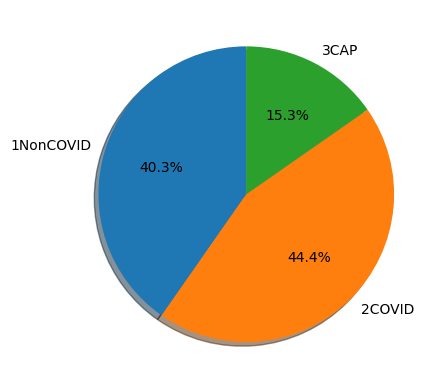

In [3]:
class_names = os.listdir(DATA_PATH)
image_count = {}
for i in class_names:
    image_count[i] = len(os.listdir(os.path.join(DATA_PATH,i)))

#Plotting Distribution of Each Classes
fig1, ax1 = plt.subplots()
ax1.pie(image_count.values(),
        labels = image_count.keys(),
        shadow=True,
        autopct = '%1.1f%%',
        startangle=90)
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_17812\1001813832.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


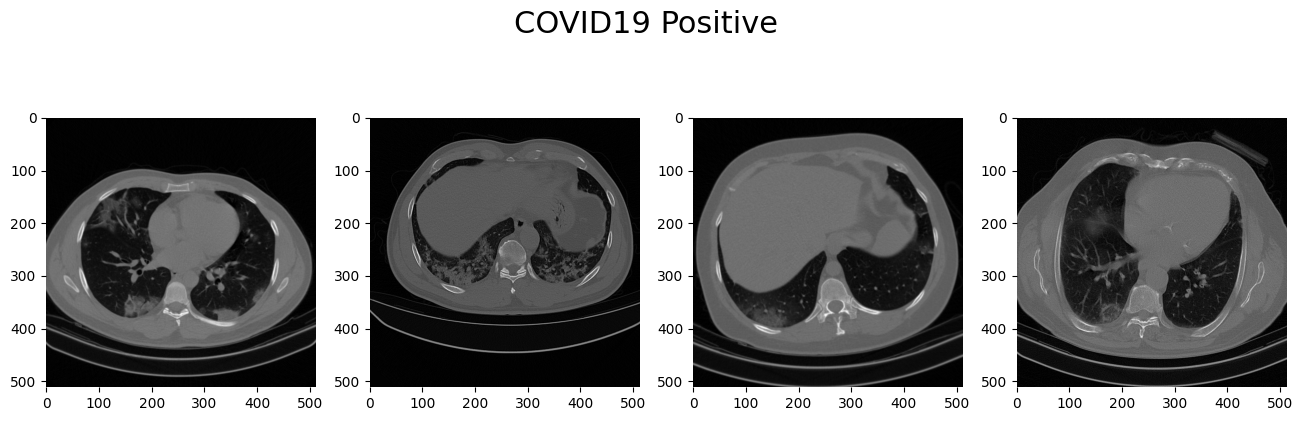

In [4]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Positive", size=22)
img_paths = os.listdir(COVID_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(COVID_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_17812\2599686391.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


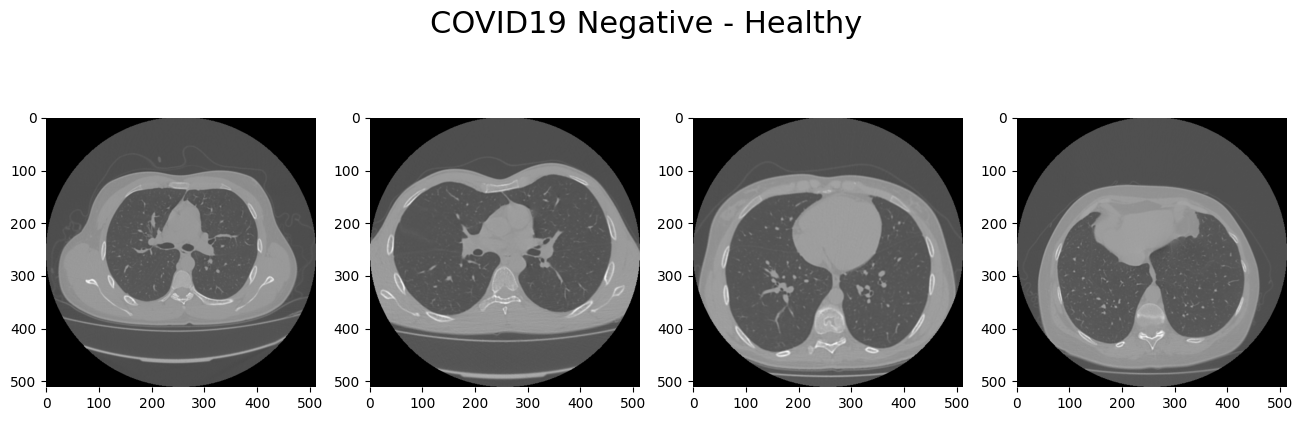

In [5]:
fig = plt.figure(figsize=(16,5))
fig.suptitle("COVID19 Negative - Healthy", size=22)
img_paths = os.listdir(NORMAL_PATH)
shuffle(img_paths)

for i,image in enumerate(img_paths[:4]):
    img = cv2.imread(os.path.join(NORMAL_PATH, image))
    plt.subplot(1,4, i+1, frameon=False)
    plt.imshow(img)
fig.show()

In [6]:
#Statistics Based on ImageNet Data for Normalisation
mean_nums = [0.485, 0.456, 0.406]
std_nums = [0.229, 0.224, 0.225]

data_transforms = {"train":transforms.Compose([
                                transforms.Resize((150,150)), #Resizes all images into same dimension
                                transforms.RandomRotation(10), # Rotates the images upto Max of 10 Degrees
                                transforms.RandomHorizontalFlip(p=0.4), #Performs Horizantal Flip over images 
                                transforms.ToTensor(), # Coverts into Tensors
                                transforms.Normalize(mean = mean_nums, std=std_nums)]), # Normalizes
                    "val": transforms.Compose([
                                transforms.Resize((150,150)),
                                transforms.CenterCrop(150), #Performs Crop at Center and resizes it to 150x150
                                transforms.ToTensor(),
                                transforms.Normalize(mean=mean_nums, std = std_nums)
                    ])}

In [7]:
def load_split_train_test(datadir, valid_size = .2):
    train_data = datasets.ImageFolder(datadir,       
                    transform=data_transforms['train']) #Picks up Image Paths from its respective folders and label them
    test_data = datasets.ImageFolder(datadir,
                    transform=data_transforms['val'])
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    dataset_size = {"train":len(train_idx), "val":len(test_idx)}
    train_sampler = SubsetRandomSampler(train_idx) # Sampler for splitting train and val images
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data,
                   sampler=train_sampler, batch_size=8) # DataLoader provides data from traininng and validation in batches
    testloader = torch.utils.data.DataLoader(test_data,
                   sampler=test_sampler, batch_size=8)
    return trainloader, testloader, dataset_size
    
trainloader, valloader, dataset_size = load_split_train_test(DATA_PATH, .2)
dataloaders = {"train":trainloader, "val":valloader}
data_sizes = {x: len(dataloaders[x].sampler) for x in ['train','val']}
class_names = trainloader.dataset.classes
print(class_names)

['1NonCOVID', '2COVID', '3CAP']


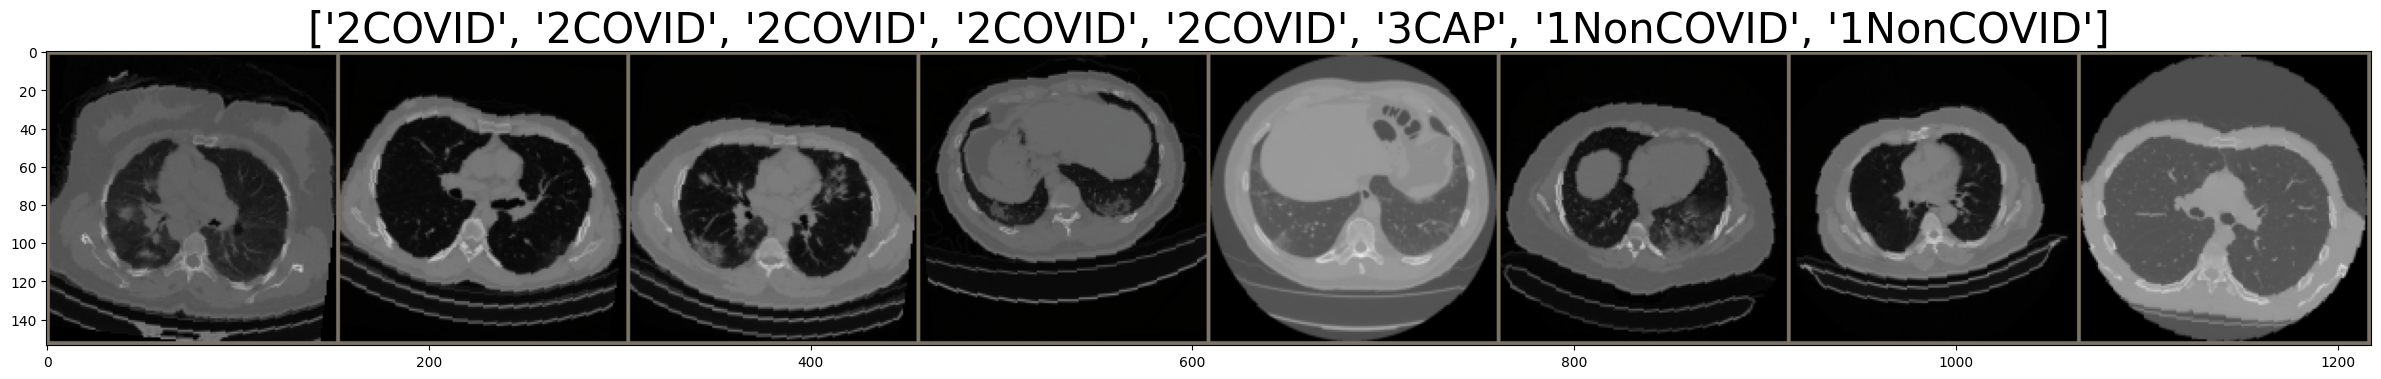

In [8]:
def imshow(inp, size =(30,30), title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = mean_nums
    std = std_nums
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=size)
    plt.imshow(inp)
    if title is not None:
        plt.title(title, size=30)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [9]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
    print("Training on GPU...")
else:
    device = torch.device("cpu")
    print("Training on CPU...")

Training on GPU...


In [10]:
def CNN_Model(pretrained=True):
    ### DENSNET ###
    #model = models.densenet121(pretrained=pretrained) # Returns Defined Densenet model with weights trained on ImageNet
    #num_ftrs = model.classifier.in_features # Get the number of features output from CNN layer
    #model.classifier = nn.Linear(num_ftrs, len(class_names)) # Overwrites the Classifier layer with custom defined layer for transfer learning
    #model = model.to(device) # Transfer the Model to GPU if available
    
    ### ResNet ###
    model_resnet = models.resnet50(pretrained=True)
    num_ftrs = model_resnet.fc.in_features

    #model_resnet.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=1)
    #model_resnet.fc = nn.Identity()

    # model_resnet.fc = nn.Sequential(
    #     nn.Linear(num_ftrs, 512),
    #     nn.ReLU(),
    #     nn.Linear(512, 256),
    #     nn.ReLU(),
    #     nn.Dropout(0.2),
    #     nn.Linear(256, 3)
    # )

    model_resnet.fc = nn.Sequential(
    nn.Linear(2048, 64),
    nn.ReLU(inplace=True),
    nn.Linear(64, 3)
)
    
    model_resnet = model_resnet.to(device)
    
    return model_resnet

model = CNN_Model(pretrained=True)

# specify loss function (categorical cross-entropy loss)
criterion = nn.CrossEntropyLoss() 

# Specify optimizer which performs Gradient Descent
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1) # Learning Scheduler

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
#print(model)
summary(model)

Layer (type:depth-idx)                   Param #
ResNet                                   --
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
│    └─Bottleneck: 2-1                   --
│    │    └─Conv2d: 3-1                  4,096
│    │    └─BatchNorm2d: 3-2             128
│    │    └─Conv2d: 3-3                  36,864
│    │    └─BatchNorm2d: 3-4             128
│    │    └─Conv2d: 3-5                  16,384
│    │    └─BatchNorm2d: 3-6             512
│    │    └─ReLU: 3-7                    --
│    │    └─Sequential: 3-8              16,896
│    └─Bottleneck: 2-2                   --
│    │    └─Conv2d: 3-9                  16,384
│    │    └─BatchNorm2d: 3-10            128
│    │    └─Conv2d: 3-11                 36,864
│    │    └─BatchNorm2d: 3-12            128
│    │    └─Conv2d: 3-13               

In [12]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters: \n{}".format(pytorch_total_params))

Number of trainable parameters: 
23639363


In [13]:
train_loss = []
train_acc = []

val_loss = []
val_acc = []
val_kappa = []

In [14]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0
            current_kappa = 0
            val_kappa = list()

            for inputs, labels in tqdm(dataloaders[phase], desc=phase, leave=True):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients in the Cache.
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                if phase == 'train':
                    optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)
                val_kappa.append(cohen_kappa_score(preds.cpu().numpy(), labels.data.cpu().numpy()))
            epoch_loss = current_loss / data_sizes[phase]
            epoch_acc = current_corrects.double() / data_sizes[phase]
            if phase == 'val':
                epoch_kappa = np.mean(val_kappa)
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f} | Kappa Score: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc, epoch_kappa))
                val_loss.append(epoch_loss)
                val_acc.append(epoch_acc)

            else:
                print('{} Loss: {:.4f} | {} Accuracy: {:.4f}'.format(
                    phase, epoch_loss, phase, epoch_acc))
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)

            # EARLY STOPPING
            if phase == 'val' and epoch_loss < best_loss:
                print('Val loss Decreased from {:.4f} to {:.4f} \nSaving Weights... '.format(best_loss, epoch_loss))
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val loss: {:.4f}'.format(best_loss))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    return model

In [15]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_handeled = 0
    ax = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
    
            for j in range(inputs.size()[0]):
                images_handeled += 1    
                ax = plt.subplot(num_images//2, 2, images_handeled)
                ax.axis('off')
                ax.set_title('Actual: {} predicted: {}'.format(class_names[labels[j].item()],class_names[preds[j]]))
                imshow(inputs.cpu().data[j], (5,5))

                if images_handeled == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [16]:
base_model = train_model(model, criterion, optimizer, exp_lr_scheduler, num_epochs=20)

Epoch 1/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.7862 | train Accuracy: 0.6592


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.7575 | val Accuracy: 0.6760 | Kappa Score: 0.4058
Val loss Decreased from inf to 0.7575 
Saving Weights... 

Epoch 2/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.6642 | train Accuracy: 0.7026


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.5935 | val Accuracy: 0.7292 | Kappa Score: 0.5211
Val loss Decreased from 0.7575 to 0.5935 
Saving Weights... 

Epoch 3/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.5610 | train Accuracy: 0.7628


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 1.0420 | val Accuracy: 0.6202 | Kappa Score: 0.4386

Epoch 4/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.4824 | train Accuracy: 0.8067


val:   0%|          | 0/428 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.4170 | val Accuracy: 0.8354 | Kappa Score: nan
Val loss Decreased from 0.5935 to 0.4170 
Saving Weights... 

Epoch 5/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.4178 | train Accuracy: 0.8351


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.4070 | val Accuracy: 0.8284 | Kappa Score: 0.6828
Val loss Decreased from 0.4170 to 0.4070 
Saving Weights... 

Epoch 6/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.3779 | train Accuracy: 0.8544


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.2894 | val Accuracy: 0.8968 | Kappa Score: 0.8132
Val loss Decreased from 0.4070 to 0.2894 
Saving Weights... 

Epoch 7/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.3446 | train Accuracy: 0.8630


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.2747 | val Accuracy: 0.8953 | Kappa Score: 0.8100
Val loss Decreased from 0.2894 to 0.2747 
Saving Weights... 

Epoch 8/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.3175 | train Accuracy: 0.8788


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.2558 | val Accuracy: 0.8985 | Kappa Score: 0.8181
Val loss Decreased from 0.2747 to 0.2558 
Saving Weights... 

Epoch 9/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.2905 | train Accuracy: 0.8893


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.2615 | val Accuracy: 0.8974 | Kappa Score: 0.8124

Epoch 10/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.2685 | train Accuracy: 0.8959


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.2434 | val Accuracy: 0.9029 | Kappa Score: 0.8233
Val loss Decreased from 0.2558 to 0.2434 
Saving Weights... 

Epoch 11/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.2463 | train Accuracy: 0.9044


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.2948 | val Accuracy: 0.8921 | Kappa Score: 0.8021

Epoch 12/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.2295 | train Accuracy: 0.9141


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.1703 | val Accuracy: 0.9339 | Kappa Score: 0.8759
Val loss Decreased from 0.2434 to 0.1703 
Saving Weights... 

Epoch 13/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.2146 | train Accuracy: 0.9187


val:   0%|          | 0/428 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.1543 | val Accuracy: 0.9377 | Kappa Score: nan
Val loss Decreased from 0.1703 to 0.1543 
Saving Weights... 

Epoch 14/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.2035 | train Accuracy: 0.9241


val:   0%|          | 0/428 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.3803 | val Accuracy: 0.8637 | Kappa Score: nan

Epoch 15/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

train Loss: 0.1885 | train Accuracy: 0.9283


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.1478 | val Accuracy: 0.9424 | Kappa Score: 0.8973
Val loss Decreased from 0.1543 to 0.1478 
Saving Weights... 

Epoch 16/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.1777 | train Accuracy: 0.9336


val:   0%|          | 0/428 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


val Loss: 0.1306 | val Accuracy: 0.9538 | Kappa Score: nan
Val loss Decreased from 0.1478 to 0.1306 
Saving Weights... 

Epoch 17/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.1721 | train Accuracy: 0.9344


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.1255 | val Accuracy: 0.9512 | Kappa Score: 0.9066
Val loss Decreased from 0.1306 to 0.1255 
Saving Weights... 

Epoch 18/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.1621 | train Accuracy: 0.9403


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.1141 | val Accuracy: 0.9561 | Kappa Score: 0.9188
Val loss Decreased from 0.1255 to 0.1141 
Saving Weights... 

Epoch 19/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.1499 | train Accuracy: 0.9445


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.1201 | val Accuracy: 0.9512 | Kappa Score: 0.9094

Epoch 20/20
----------


train:   0%|          | 0/1711 [00:00<?, ?it/s]

c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:697: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)


train Loss: 0.1420 | train Accuracy: 0.9489


val:   0%|          | 0/428 [00:00<?, ?it/s]

val Loss: 0.1306 | val Accuracy: 0.9477 | Kappa Score: 0.9002

Training complete in 44m 54s
Best val loss: 0.1141


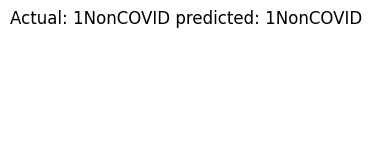

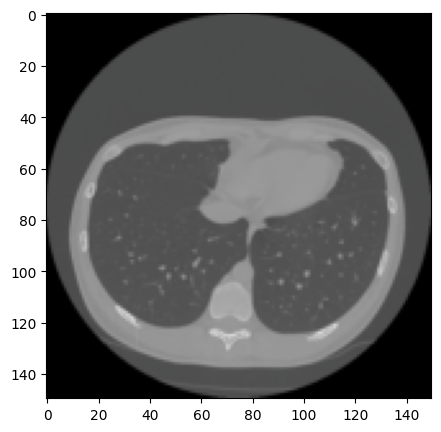

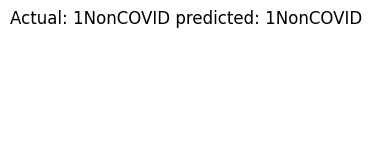

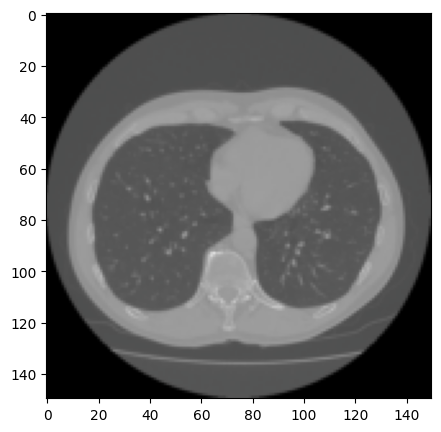

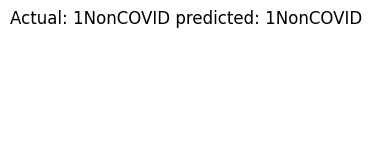

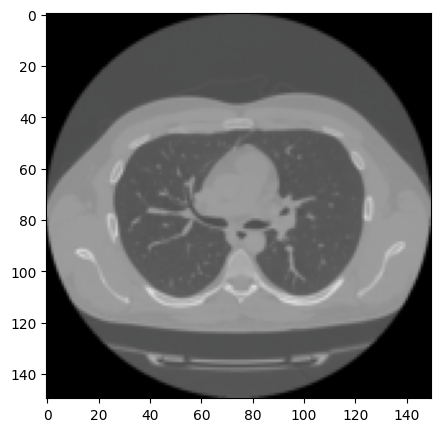

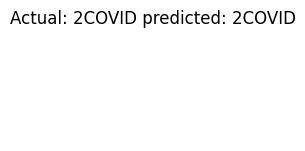

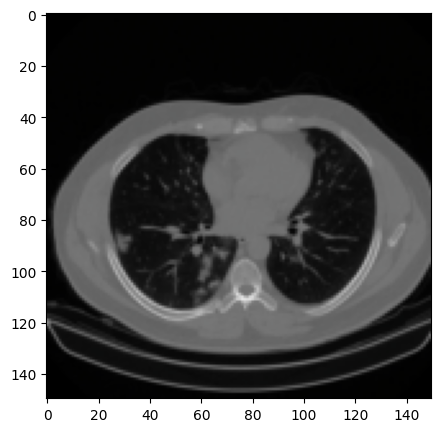

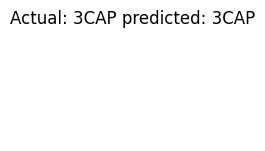

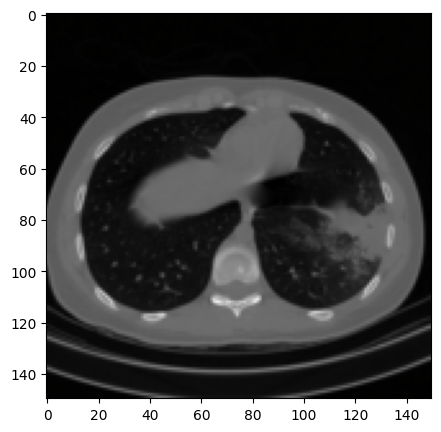

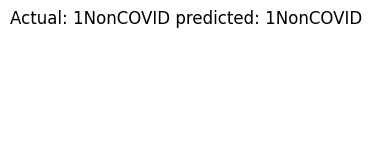

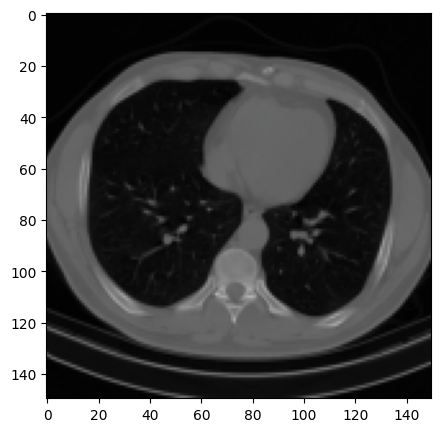

In [17]:
visualize_model(base_model)
plt.show()

In [95]:
COVID_TEST = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train/2COVID"
NORMAL_TEST = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train/1NonCOVID"
CAP_TEST = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train/3CAP"

TEST_DATA_PATH = "C:/Users/PC/Documents/FYP/FYP/Code/curated_data/train"

In [96]:
test_transforms = transforms.Compose([
                                      transforms.Resize((150,150)),
                                      transforms.CenterCrop(150),
                                      transforms.ToTensor(),
                                      transforms.Normalize(mean=mean_nums, std=std_nums)
])


test_image = datasets.ImageFolder(TEST_DATA_PATH, transform=test_transforms)

testloader = torch.utils.data.DataLoader(test_image, batch_size=1)

In [97]:
y_pred_list = []
y_true_list = []
with torch.no_grad():
    for x_batch, y_batch in tqdm(testloader, leave=True):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_test_pred = base_model(x_batch)
        y_test_pred = torch.log_softmax(y_test_pred, dim=1)
        _, y_pred_tag = torch.max(y_test_pred, dim = 1)
        y_pred_list.append(y_pred_tag.cpu().numpy())
        y_true_list.append(y_batch.cpu().numpy())

  0%|          | 0/17104 [00:00<?, ?it/s]

In [98]:
y_pred_list = [i[0] for i in y_pred_list]
y_true_list = [i[0] for i in y_true_list]

In [99]:
print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.92      0.99      0.95      6893
           1       0.99      0.92      0.95      7593
           2       1.00      0.99      0.99      2618

    accuracy                           0.96     17104
   macro avg       0.97      0.97      0.97     17104
weighted avg       0.96      0.96      0.96     17104



In [100]:
import matplotlib.pyplot as plt
import numpy as np
import itertools
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

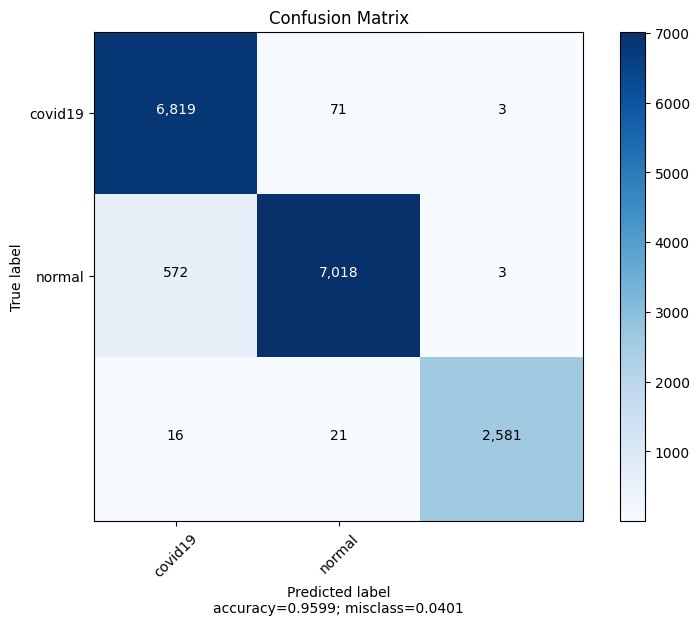

In [101]:
from sklearn.metrics import confusion_matrix

cm =  confusion_matrix(y_true_list, y_pred_list)

plot_confusion_matrix(cm = cm, 
                      normalize    = False,
                      target_names = ['covid19','normal'],
                      title        = "Confusion Matrix")

In [ ]:
torch.save(base_model.state_dict(), 'C:/Users/PC/Documents/FYP/FYP/Code/Model/Model Ver1.0/Model Ver1.pth')